In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
data_path = '/content/drive/My Drive/Colab Notebooks/data/'

# Deep Learning - Day 2 - Challenge `Credit Card`

In [12]:
''' Linear Algebra'''
import pandas as pd
import numpy as np
''' Data visualisation'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


All the previous exercises made you take a closer look at all the different parts of a neural network: the architecture, the compilation and the fitting.

Let's now work on a real-life dataset that has a lot of data!

The data
For this open challenge, you will work with data extracted from credit card transactions. As these are sensitive data, from all the 31 columns, only 3 are known: the rest are data that have been transformed to anonymize them (in fact, they are PCA projections of initial data).

The other three known columns are:

- "TIME": the time elapsed between the transaction and the first transaction in the dataset
- "AMOUNT": the amount of the transaction
- "CLASS": 0 means that the transaction is valid whereas 1 means that it is a fraud.


Start by downloading the data on the Kaggle website here - you can read more about the data over there.

## Transaction Amount Prediction


Here, you will work on a regression task, where you will try to predict the amount of the transaction, which is the "AMOUNT" column. For this task, you will drop the "CLASS" dataset are you are not supposed to know if the transaction is a fraud or not.

- Build you architecture, compile it and fit in on the data.
- Do not forget to validate your result with a test set (or even better, with a real cross-validation)
- To know whether your score is correct or not, compare it to a simple benchmark.

In [13]:
# YOUR CODE HERE
df = pd.read_csv(data_path+'creditcard.csv')

In [14]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
df.shape

(284807, 31)

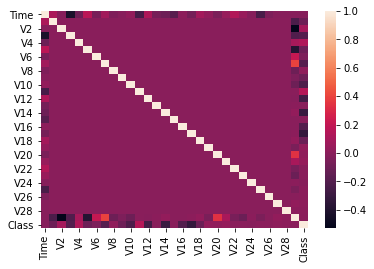

In [16]:
sns.heatmap(df.corr())

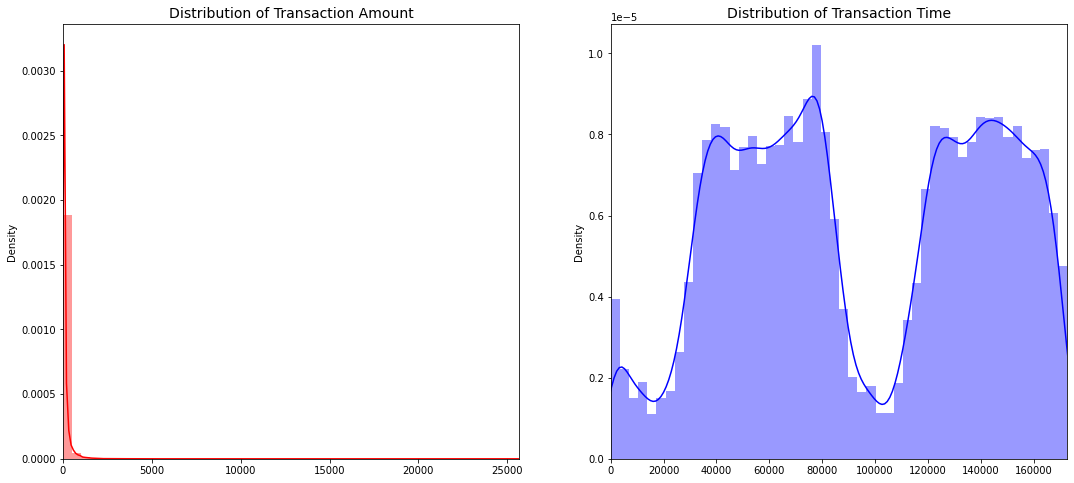

In [17]:
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,8))

''' --- Distribution of the Amount values --- '''

amount_val = df['Amount'].values


sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

''' --- Distribution of the Transaction Times --- '''

time_val = df['Time'].values

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()


In [21]:
# Select data
X = df.drop(columns=['Class','Amount'],axis=1)
y = df['Amount']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((199364, 29), (85443, 29), (199364,), (85443,))

In [23]:
# RobustScaler is less prone to outliers.

rb_scaler = RobustScaler()

rb_scaler.fit(X_train['Time'].values.reshape(-1, 1))



X_train.loc[:,'Time'] = rb_scaler.transform(X_train.loc[:,'Time'].values.reshape(-1,1))
X_test.loc[:,'Time'] = rb_scaler.transform(X_test.loc[:,'Time'].values.reshape(-1,1))


### RegBenchmark

In [24]:
# Benchmark
y_pred = np.mean(y_train)
print(f'The mean prediction is {y_pred:.3f}')

benchmark_absolute_error = [np.abs(y - y_pred) for y in y_test]
benchmark_mean_absolute_error = np.mean(benchmark_absolute_error)

print(f'The benchmark mean absolute error is of {benchmark_mean_absolute_error:.3f}')

The mean prediction is 88.800
The benchmark mean absolute error is of 102.814


In [25]:
def plot_loss_mae(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

### RegNN

In [26]:
X_train.shape[1]

29

In [27]:
def deep_regression():

    # Model architecture
    model = models.Sequential()
    model.add(layers.Dense(25, activation='relu', input_dim=X_train.shape[1]))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
#     # Learning rate schedule
#     initial_learning_rate = 0.05
    
#     lr_schedule = ExponentialDecay(
#         initial_learning_rate, decay_steps=100, decay_rate=0.3,
#     )
    
#     adam = Adam(learning_rate=lr_schedule)

    
    # Model compilation
    model.compile(optimizer='adam',
                  loss='mse',
                 metrics=['mae'])
    
    print(model.summary())
    
    return model

In [28]:
deep_reg = deep_regression()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                750       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
%%time
# Fitting the model
es = EarlyStopping(patience=10, restore_best_weights=True)

history_deep_reg = deep_reg.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=1000,
                    batch_size=32, 
                    verbose=1, 
                    callbacks=[es])

Epoch 1/1000
4362/4362 [==============================] - 8s 2ms/step - loss: 8640.5039 - mae: 27.9269 - val_loss: 2915.7913 - val_mae: 17.0142
Epoch 2/1000
4362/4362 [==============================] - 7s 2ms/step - loss: 1849.6881 - mae: 13.4470 - val_loss: 1372.0027 - val_mae: 12.0571
Epoch 3/1000
4362/4362 [==============================] - 7s 2ms/step - loss: 1289.7421 - mae: 11.7182 - val_loss: 1012.0057 - val_mae: 10.5047
Epoch 4/1000
4362/4362 [==============================] - 7s 2ms/step - loss: 1033.0564 - mae: 10.5305 - val_loss: 925.8002 - val_mae: 9.7162
Epoch 5/1000
4362/4362 [==============================] - 8s 2ms/step - loss: 894.0022 - mae: 10.0194 - val_loss: 920.3271 - val_mae: 10.1199
Epoch 6/1000
4362/4362 [==============================] - 7s 2ms/step - loss: 717.7310 - mae: 9.4100 - val_loss: 863.7306 - val_mae: 8.9561
Epoch 7/1000
4362/4362 [==============================] - 7s 2ms/step - loss: 668.0466 - mae: 9.0632 - val_loss: 884.9458 - val_mae: 8.9944
Epoc

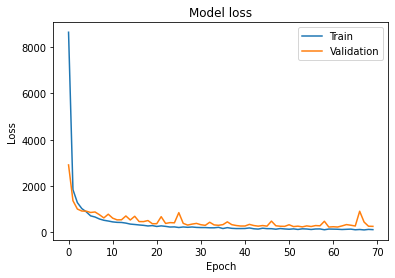

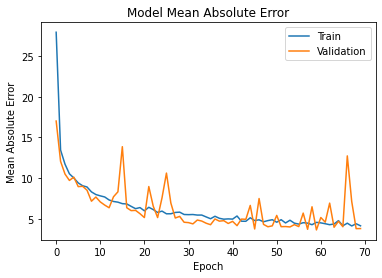

In [36]:
plot_loss_mae(history_deep_reg)

In [37]:
res_deep_reg = deep_reg.evaluate(X_test, y_test, verbose=0)
print(" ---------- MAE for the deep_regression_v1 ---------")
print(f'{res_deep_reg[1]:.4f}')


 ---------- MAE for the deep_regression_v1 ---------
3.4977


In [38]:
print(" ---------- MAE the dummy regressor  ---------")
print(f"{benchmark_mean_absolute_error:.4f}")

 ---------- MAE the dummy regressor  ---------
102.8142


## Fraud detection


In this second task, you can reload your data and work on the detection of the fraud, which is in the "CLASS" column. You again have to build a neural network for this classification task. But first, you should look at the number of occurences of the 0 (= not a fraud) class against the 1 (= fraud) class. You can think of strategies to work this out. Otherwise, try to achieve the best possible score.

### Rebalancing classes

In this `fraud detection` challenge, the classes are extremely imbalanced:
* 99.8 % of normal transactions
* 0.2 % of fraudulent transactions

In [40]:
# Select data
X = df.drop(columns=['Class'],axis=1)
y = df['Class']


In [41]:
pd.Series(y).value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [44]:
pd.Series(y).value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

The model won't be able to detect frauds unless we apply some rebalancing strategies:
1. Do not oversample the minority class by duplicating occurences, this will result in `data leakage`
2. Do not downsample the majority class, this will result in dropping almost 99% of your data 
3. We can use <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/">Synthetic Minority Oversampling Technique</a> to generate new datapoints by weighting the existing ones
4. We can use <a href="https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/">RandomUnderSampler</a> to downsample a little bit the majority class
5. It is not advised to rebalance at 50/50 because this is also far from the reality

In [47]:
# Sampling strategies
over = SMOTE(sampling_strategy=0.05)
under = RandomUnderSampler(sampling_strategy=0.3)


In [48]:
# Pipelining the two strategies
steps =  [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)


# Rebalance the dataset
X_resampled, y_resampled = pipeline.fit_resample(X, y)


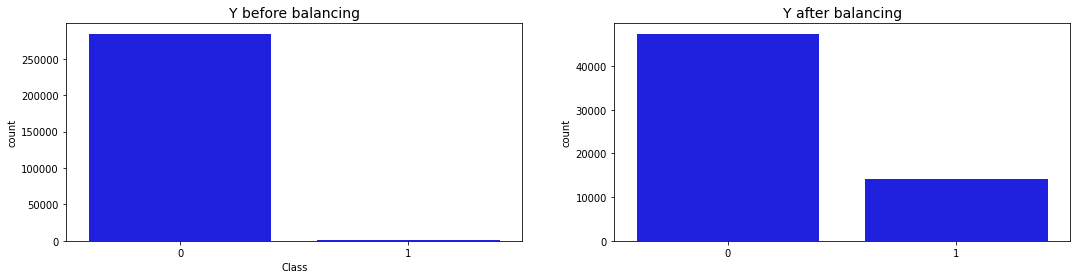

In [49]:
# plotting
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

''' Before rebalancing classes'''

sns.countplot(y, ax=ax[0], color='b')
ax[0].set_title('Y before balancing', fontsize=14)

''' After rebalancing classes'''

sns.countplot(y_resampled, ax=ax[1], color='b')
ax[1].set_title('Y after balancing', fontsize=14);

In [50]:
print(f"----- len(y) -----")
print(len(y))

print(f"----- len(y_resampled) -----")
print(len(y_resampled))

print(f"----- len(y_resampled) / len(y) -----")
print(round(len(y_resampled) / len(y),3))

----- len(y) -----
284807
----- len(y_resampled) -----
61598
----- len(y_resampled) / len(y) -----
0.216


In [51]:
pd.Series(y).value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [54]:
pd.Series(y).value_counts(normalize = True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [52]:
pd.Series(y_resampled).value_counts()

0    47383
1    14215
dtype: int64

In [53]:
pd.Series(y_resampled).value_counts(normalize = True)

0    0.76923
1    0.23077
dtype: float64

In [55]:
print(f"----- len(y_0) ----------------------")
print(pd.Series(y).value_counts()[0])

print(f"----- len(y_resampled_0) ------------")
print(pd.Series(y_resampled).value_counts()[0])

print(f"----- len(y_resampled) / len(y) -----")
print(round(pd.Series(y_resampled).value_counts()[0] / pd.Series(y).value_counts()[0],3))

----- len(y_0) ----------------------
284315
----- len(y_resampled_0) ------------
47383
----- len(y_resampled) / len(y) -----
0.167


In [56]:
print(f"----- len(y_1) ----------------------")
print(pd.Series(y).value_counts()[1])

print(f"----- len(y_resampled_1) ------------")
print(pd.Series(y_resampled).value_counts()[1])

print(f"----- len(y_resampled_1) / len(y_1) -----")
print(round(pd.Series(y_resampled).value_counts()[1] / pd.Series(y).value_counts()[1],3))

----- len(y_1) ----------------------
492
----- len(y_resampled_1) ------------
14215
----- len(y_resampled_1) / len(y_1) -----
28.892


In [57]:
round(pd.Series(y_resampled).value_counts()/len(y_resampled),3)

0    0.769
1    0.231
dtype: float64

### Stratified Holdout

In [58]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 0, shuffle = True, stratify = y_resampled)

In [83]:
X.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [84]:
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns

X_test = pd.DataFrame(X_test)
X_test.columns = X.columns

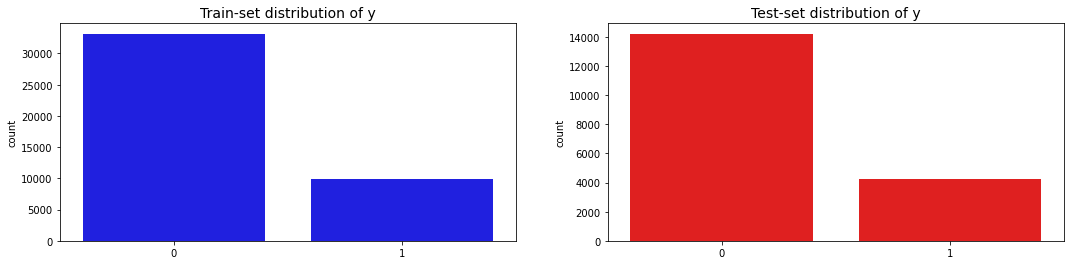

In [59]:
warnings.filterwarnings('ignore')
fig, ax = plt.subplots(1, 2, figsize=(18,4))

sns.countplot(y_train, ax=ax[0], color='b')
ax[0].set_title('Train-set distribution of y', fontsize=14)

sns.countplot(y_test, ax=ax[1], color='r')
ax[1].set_title('Test-set distribution of y', fontsize=14)

plt.show()


In [78]:
X_train[:,0].reshape(-1,1).shape

(43118, 1)

In [86]:
# Scaling
rob_scaler = RobustScaler().fit(X_train['Time'].values.reshape(-1,1))
X_train.loc[:,'Time'] = rob_scaler.transform(X_train.loc[:,'Time'].values.reshape(-1,1))
X_test.loc[:,'Time'] = rob_scaler.transform(X_test.loc[:,'Time'].values.reshape(-1,1))

rob_scaler = RobustScaler().fit(X_train['Amount'].values.reshape(-1,1))
X_train.loc[:,'Amount'] = rob_scaler.transform(X_train.loc[:,'Amount'].values.reshape(-1,1))
X_test.loc[:,'Amount'] = rob_scaler.transform(X_test.loc[:,'Amount'].values.reshape(-1,1))

### Classifier NN

In [87]:
from tensorflow.keras.metrics import  Recall

In [88]:
def classif_nn():

    optimizer = Adam(lr=0.0001)

    # Model architecture
    model = models.Sequential()
    model.add(layers.Dense(64, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=[Recall()])
    return model

In [90]:
binary_classif_nn = classif_nn()
binary_classif_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1984      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)               

In [91]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history_binary_classif_nn = binary_classif_nn.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=100,
                    batch_size=16, 
                    verbose=0, 
                    callbacks=[es])

In [92]:
history_binary_classif_nn.history.keys()

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])

In [95]:
def plot_loss_recall(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()
    

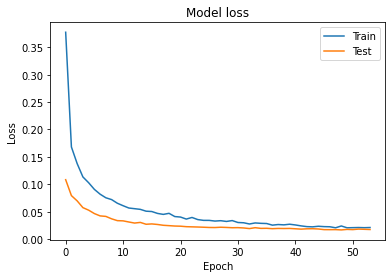

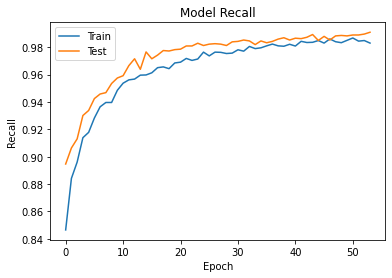

In [96]:
plot_loss_recall(history_binary_classif_nn)

### Recall Score

In [97]:
binary_classif_nn.evaluate(X_test, y_test, verbose=0)

[0.0160004161298275, 0.9896834492683411]

### Confusion Matrix

In [98]:
# Confusion Matrix
y_pred = binary_classif_nn.predict_classes(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[14170,    45],
       [   44,  4221]])

In [99]:
y_pred.shape

(18480, 1)

In [100]:
y_test.shape

(18480,)

#### Custom CM

In [101]:
import numpy as np


def plot_confusion_matrix_custom(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    recall = cm[1][1]/cm[1].sum()

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f};recall={:0.4f}'.format(accuracy, misclass,recall))
    plt.show()

#### Fraud detection

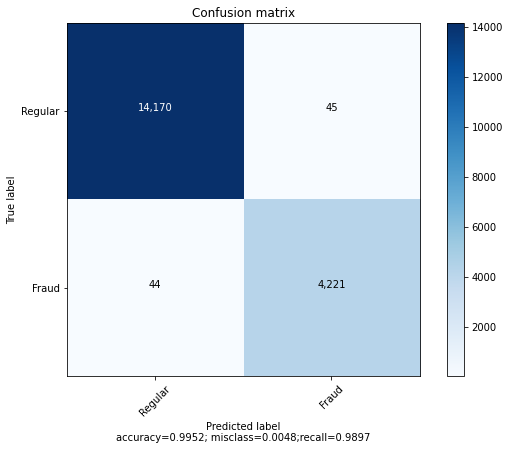

In [102]:
plot_confusion_matrix_custom(cm,['Regular','Fraud'],normalize=False)